In [12]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from Sampling import MetropolisHastingsSampler
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from GaLa import llaplace
from NN import DNN

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

The first 2 roots are: [1.5707963267941523, 2.153747972623023]


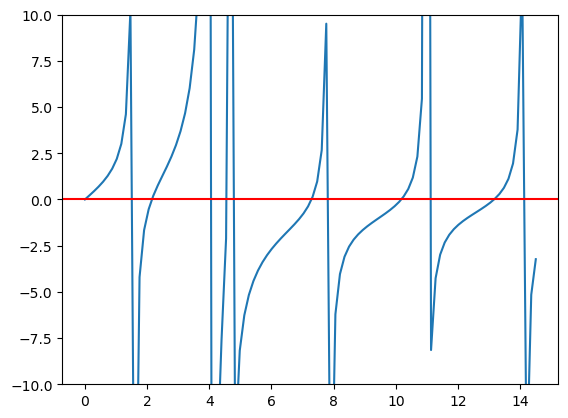

In [13]:
def tang_eq(x):
    return np.tan(x) - 8*(x/(x**2 - 16))

intervals = [(1,2),(2,3),(3.8,4.1),(4.1,4.6),(4.7,4.8),(7.2,7.3),(7.3,8),(10,10.2),(10.2,11.5),(13,13.2),(14,14.5)]
n = 2

root_finder = RootFinder(n, tang_eq, intervals)
roots = root_finder.find_roots()
root_finder.plot_equation()

print(f"The first {n} roots are: {roots}")

theta_t = np.array([0.09762701, 0.43037873, 0.20552675, 0.08976637, -0.1526904, 0.29178823, -0.12482558, 0.783546, 0.92732552, -0.23311696])

In [14]:
def k_function(data_domain,w=roots):
    
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

In [15]:
# Number of observations
epochs = 500

N = [500,1000,1500]
sample_size = [50,75,125,150]
weights = [10,20]

lr = 0.01


In [16]:
# data_parameters = samples_param(3000, nparam=2)
# param_train, param_test = data_parameters[:1500,:],  data_parameters[1500:,:]

# for w in weights:
#     for nobs in N:

#         dataset = dGDataset(size = nobs, param=param_train)

#         x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)

#         for ss in sample_size:
#                 layers = [3] + 1*[w] + [1]
                
#                 model = DNN(layers)

#                 dataloader = DataLoader(dataset, batch_size=ss, shuffle=False)

#                 loss = torch.nn.MSELoss(reduction ='mean')

#                 optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#                 loss_adam = train_adam(dataloader,model, loss, optimizer, epochs,param_val,x_val,sol_val, device)

#                 optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=5000, max_eval=None, 
#                     tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" )

#                 loss_lbfgs = train_lbfgs(dataloader,model, loss, optimizer,param_val,x_val,sol_val, device)
                
#                 np.save(f'./Models/adam_train_w{w}_N{nobs}_batch{ss}.npy', loss_adam[0])
#                 np.save(f'./Models/adam_test_w{w}_N{nobs}_batch{ss}.npy', loss_adam[1]) 
#                 np.save(f'./Models/lbfgs_train_w{w}_N{nobs}_batch{ss}.npy', loss_lbfgs[0]) 
#                 np.save(f'./Models/lbfgs_test_w{w}_N{nobs}_batch{ss}.npy', loss_lbfgs[1]) 

#                 path = f"./Models/1dElliptic_PDE2_w{w}_N{nobs}_batch{ss}.pt"
#                 torch.save(model.state_dict(),path)

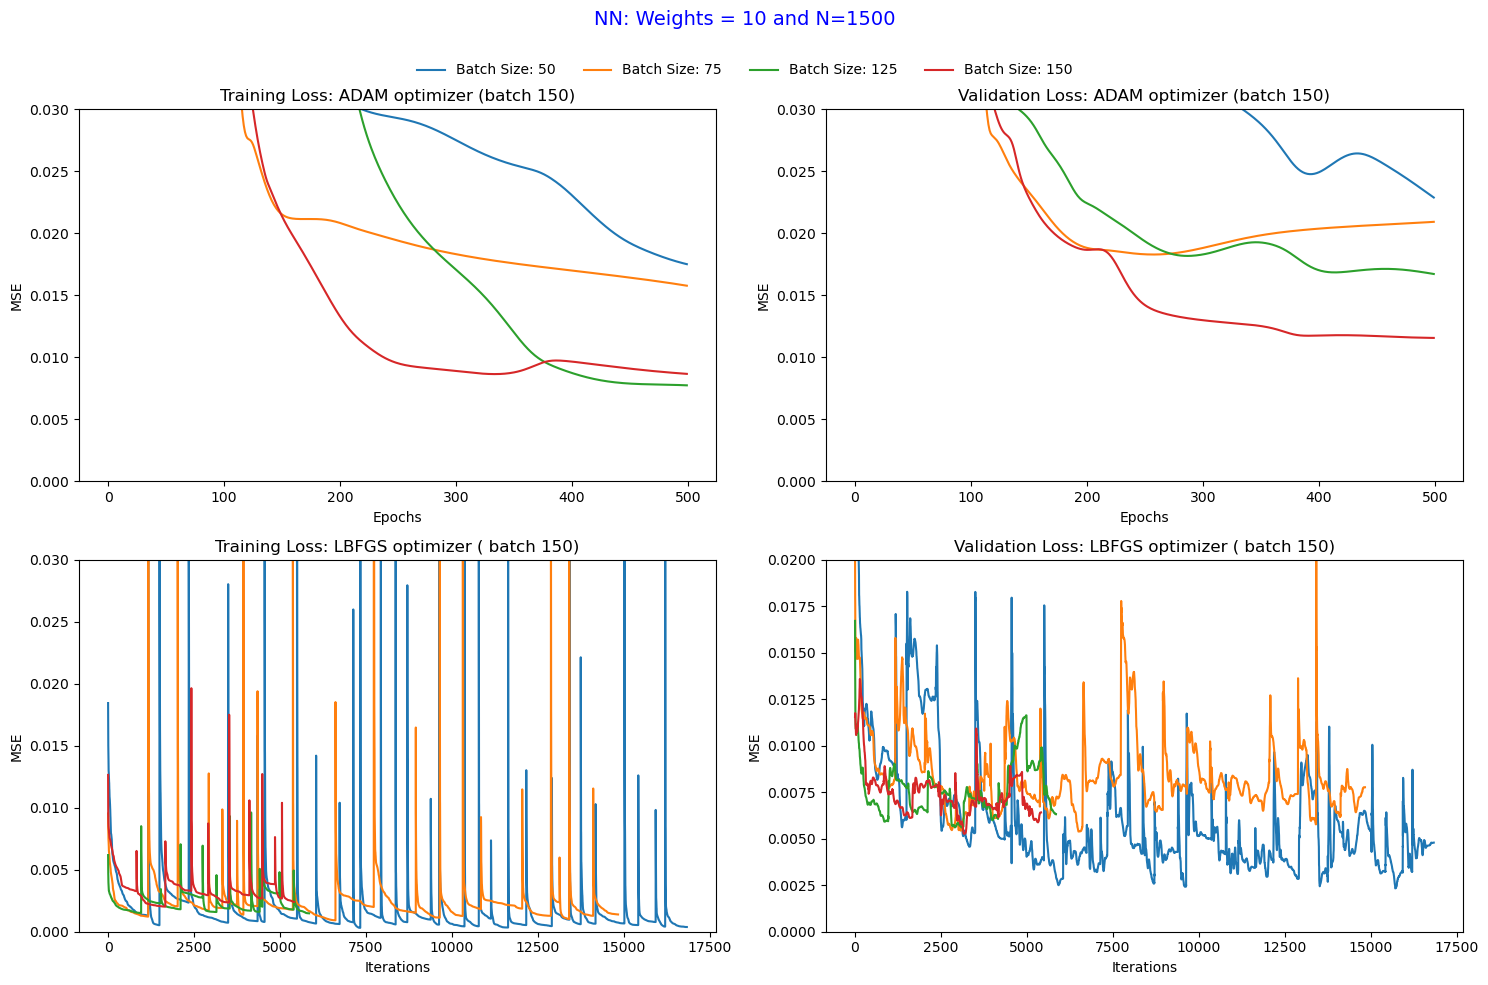

In [17]:
w,nobs =  10,1500

plot_loss_dynamics(w, nobs, sample_size, adltrain=0.03, adltest=0.03, lbfgsltrain=0.03, lbfgsltest=0.02)

# Error Analysis

In [18]:
ntest, vert = 1500, 30

x_test,param_test, sol_test = generate_test_data(ntest, vert=vert)

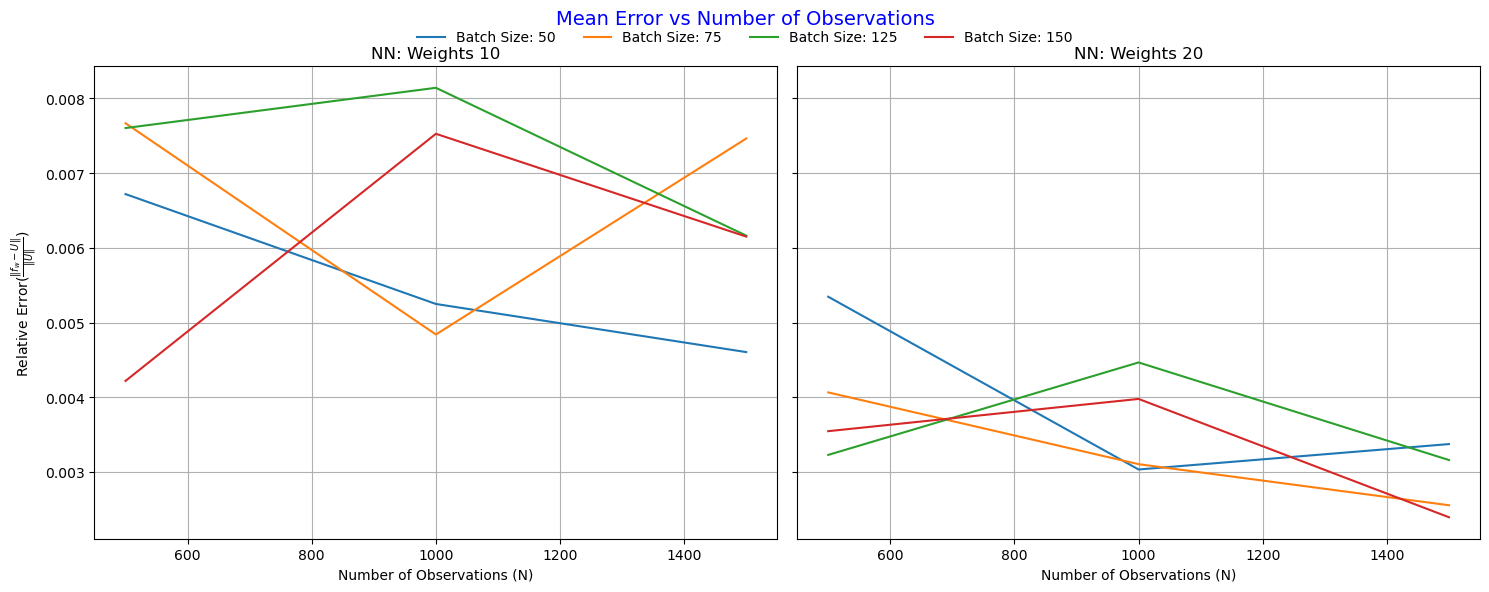

In [19]:
path = "./Models/1dElliptic_PDE2_w{w}_N{nobs}_batch{ss}.pt"

plot_mean_error(weights, sample_size, N, param_test, x_test, sol_test, DNN,path)

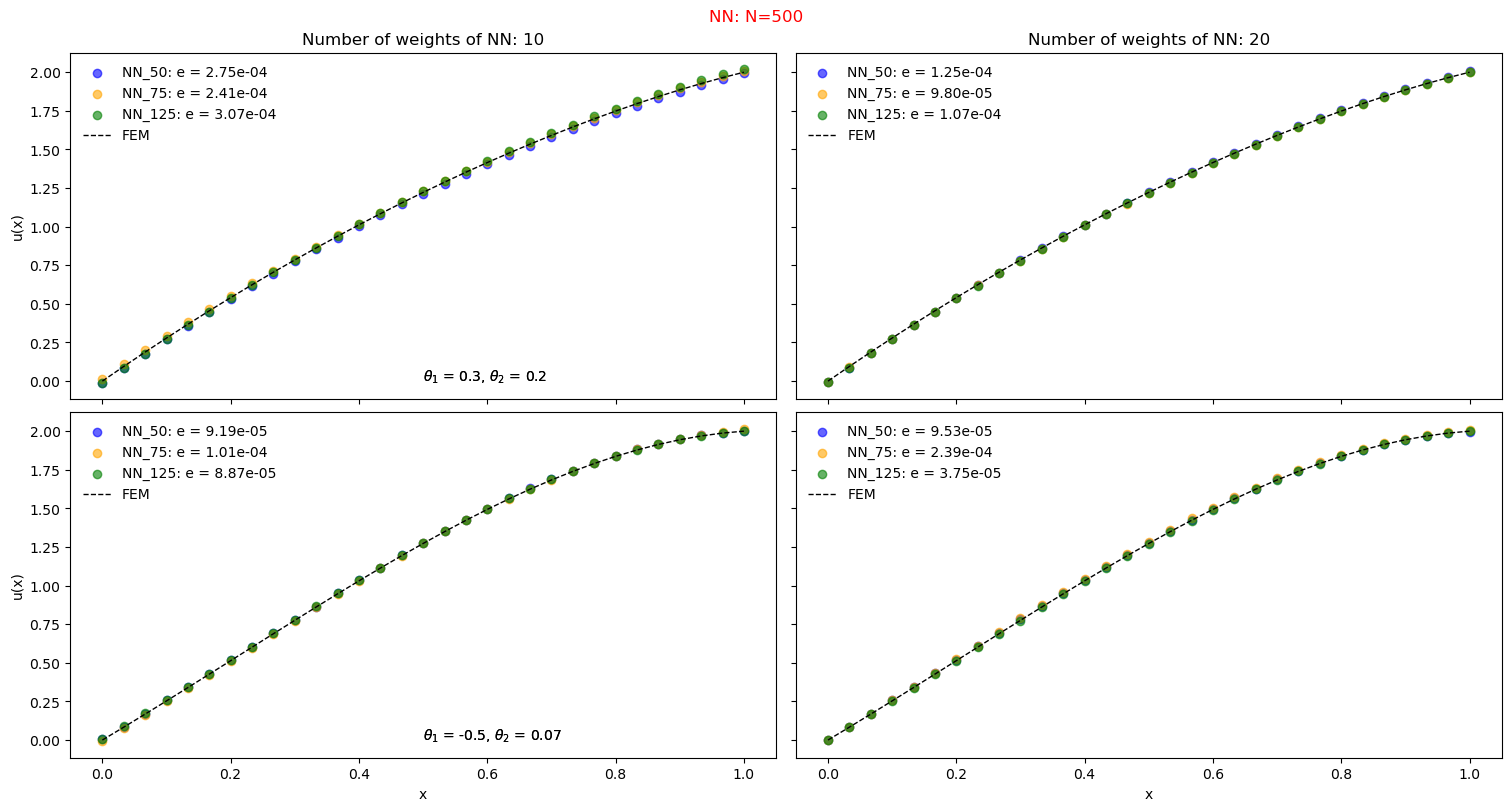

In [20]:
plot_nn_vs_fem(weights, param_test, x_test, sol_test, sample_size,path ,DNN, nobs=500)

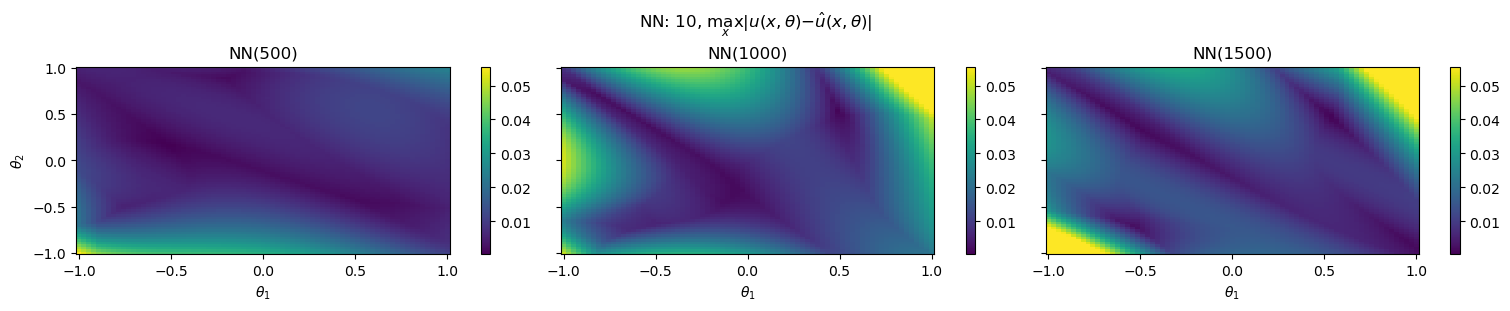

In [21]:
# Define intervals for root finding
intervals = [(1, 2), (2, 3), (3.8, 4.1), (4.1, 4.6), (4.7, 4.8), 
                 (7.2, 7.3), (7.3, 8), (10, 10.2), (10.2, 11.5), 
                 (13, 13.2), (14, 14.5)]
    
def tang_eq(x):
    """Equation for root-finding."""
    return np.tan(x) - 8 * (x / (x**2 - 16))

    # Initialize root finder and find roots (assuming RootFinder class is already implemented)
root_finder = RootFinder(2, tang_eq, intervals)

roots = root_finder.find_roots()

NNpr, grid = 10, 75

results, X, Y = compute_max_error(N, NNpr, roots ,grid=75, 
                  model_dir='./Models/', model_prefix='1dElliptic_PDE2',batch = 150)

plot_max_errors(N, results, X, Y, NNpr)

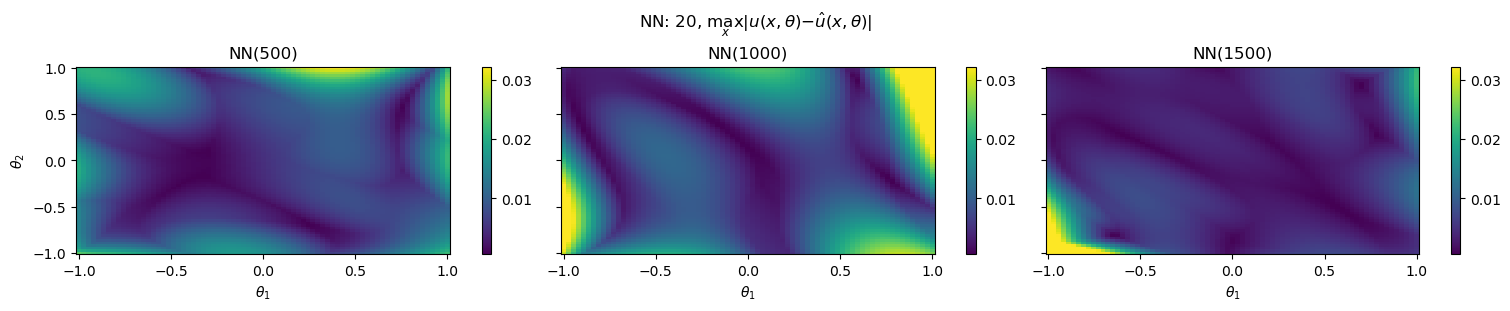

In [22]:
    # Initialize root finder and find roots (assuming RootFinder class is already implemented)
root_finder = RootFinder(2, tang_eq, intervals)

roots = root_finder.find_roots()

NNpr, grid = 20, 75

results, X, Y = compute_max_error(N, NNpr, roots ,grid=75, 
                  model_dir='./Models/', model_prefix='1dElliptic_PDE2',batch = 150)

plot_max_errors(N, results, X, Y, NNpr)

In [27]:
results[:,:,-1].mean()

0.0053451142250483625

# Generating Artificial Data for Inverse Problem

(Text(0.5, 0, 'x'), Text(0, 0.5, 'u(x)'))

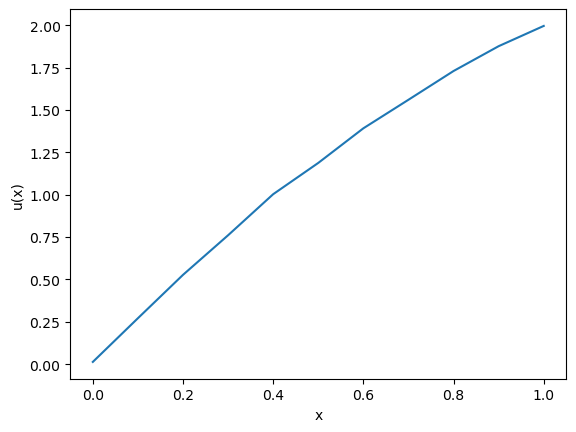

In [20]:
obs = 10
nn_nt = [10,50,100]
mean, std = 0,np.sqrt(1e-4)
theta_th=np.array([0.098, 0.430])

obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=std)

plt.plot(obs_points,obs_sol.reshape(-1))
plt.xlabel("x"), plt.ylabel("u(x)")

# Inverse problem through MCMC

In [ ]:
sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = std,numerical = True, roots=roots, vert=10)

samp_num,dt_tracker_num = sampler.run_sampler(n_chains=100000)

np.save(f'./Models/FEM_Samples.npy', samp_num)
np.save(f'./Models/FEM_Step.npy', dt_tracker_num)

#samp_num,dt_tracker_num = np.load(f'./Models/FEM_Samples.npy'),np.load(f'./Models/FEM_Step.npy')

In [23]:
samples,tracker = dict(),dict()

for nobs in N:
    layers = [3] + 1*[20] + [1]
    model = DNN(layers)
    model.load_state_dict(torch.load(f"./Models/1dElliptic_PDE2_w20_N{nobs}_batch150.pt"))
    model.eval()

    sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=model,sig = std)
    nsamples, dt_progres = sampler.run_sampler(n_chains=100000)
    samples[nobs], tracker[nobs] = nsamples,dt_progres

    np.save(f'./Models/NN_{nobs}_Samples.npy', samples[nobs])
    np.save(f'./Models/NN_{nobs}_Step.npy', tracker[nobs])


# for nobs in N:
#     samples[nobs] = np.load(f'./Models/NN_{nobs}_adam_Samples.npy')
#     tracker[nobs] = np.load(f'./Models/NN_{nobs}_adam_Step.npy')

Iteration 0, Acceptance Rate: 0.000, Step Size: 0.3830
Iteration 10000, Acceptance Rate: 0.155, Step Size: 0.1593
Iteration 20000, Acceptance Rate: 0.166, Step Size: 0.1534
Iteration 30000, Acceptance Rate: 0.173, Step Size: 0.1505
Iteration 40000, Acceptance Rate: 0.178, Step Size: 0.1489
Iteration 50000, Acceptance Rate: 0.181, Step Size: 0.1475
Iteration 60000, Acceptance Rate: 0.184, Step Size: 0.1465
Iteration 70000, Acceptance Rate: 0.186, Step Size: 0.1458
Iteration 80000, Acceptance Rate: 0.187, Step Size: 0.1451
Iteration 90000, Acceptance Rate: 0.190, Step Size: 0.1447
Final Acceptance Rate: 0.191
Iteration 0, Acceptance Rate: 0.000, Step Size: 0.3830
Iteration 10000, Acceptance Rate: 0.141, Step Size: 0.1617
Iteration 20000, Acceptance Rate: 0.151, Step Size: 0.1539
Iteration 30000, Acceptance Rate: 0.157, Step Size: 0.1499
Iteration 40000, Acceptance Rate: 0.161, Step Size: 0.1474
Iteration 50000, Acceptance Rate: 0.166, Step Size: 0.1456
Iteration 60000, Acceptance Rate: 0

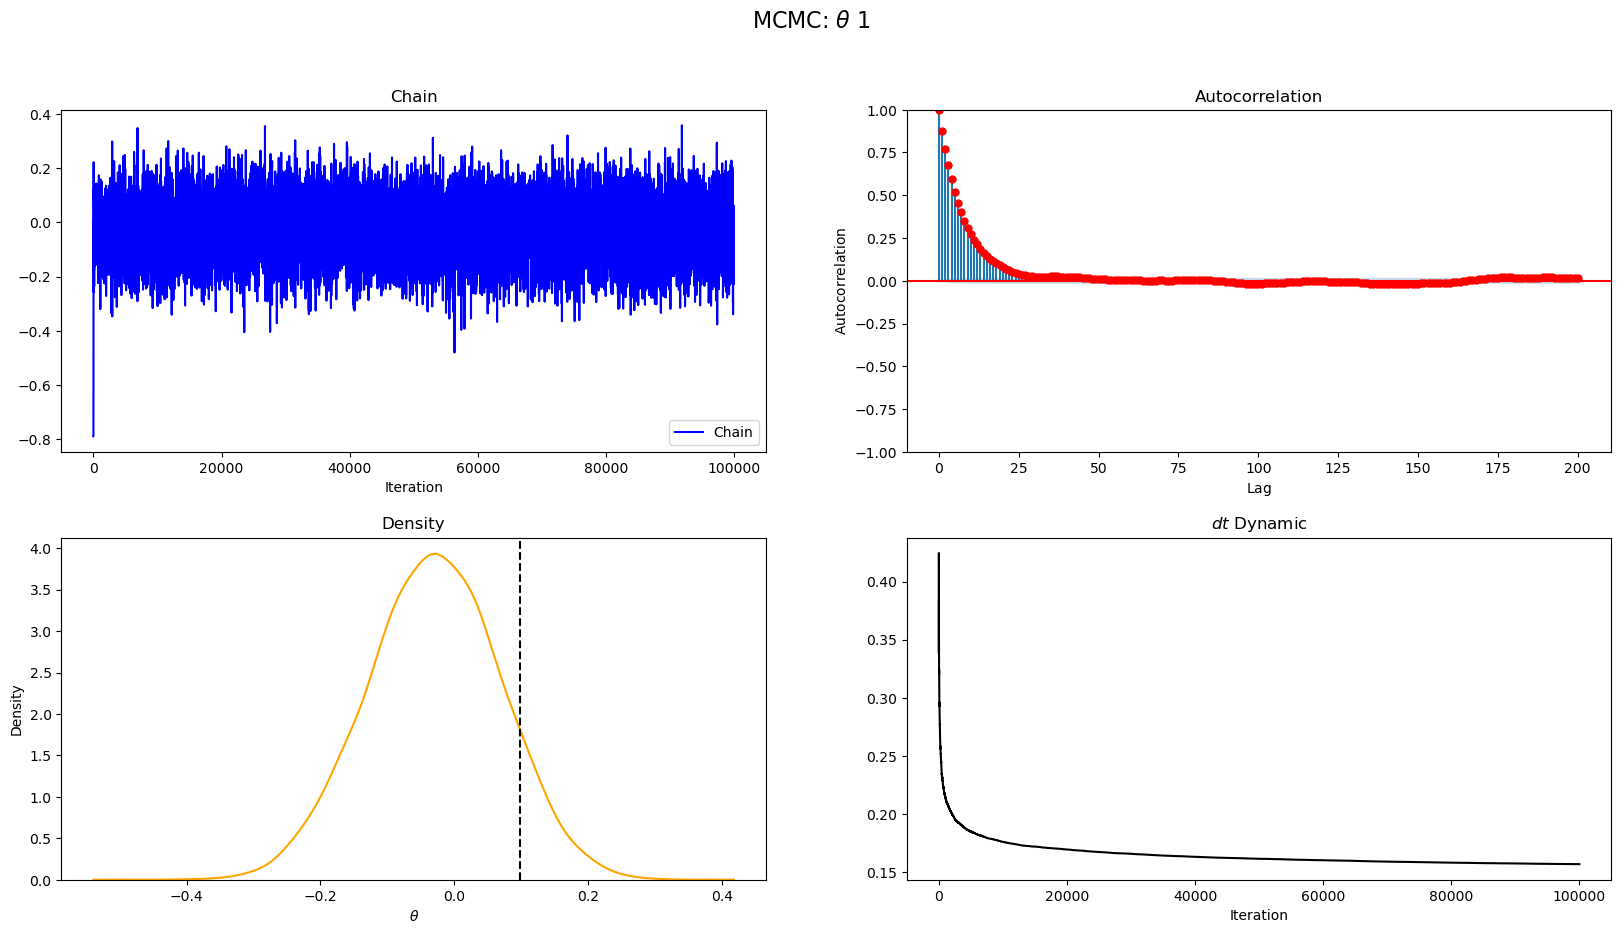

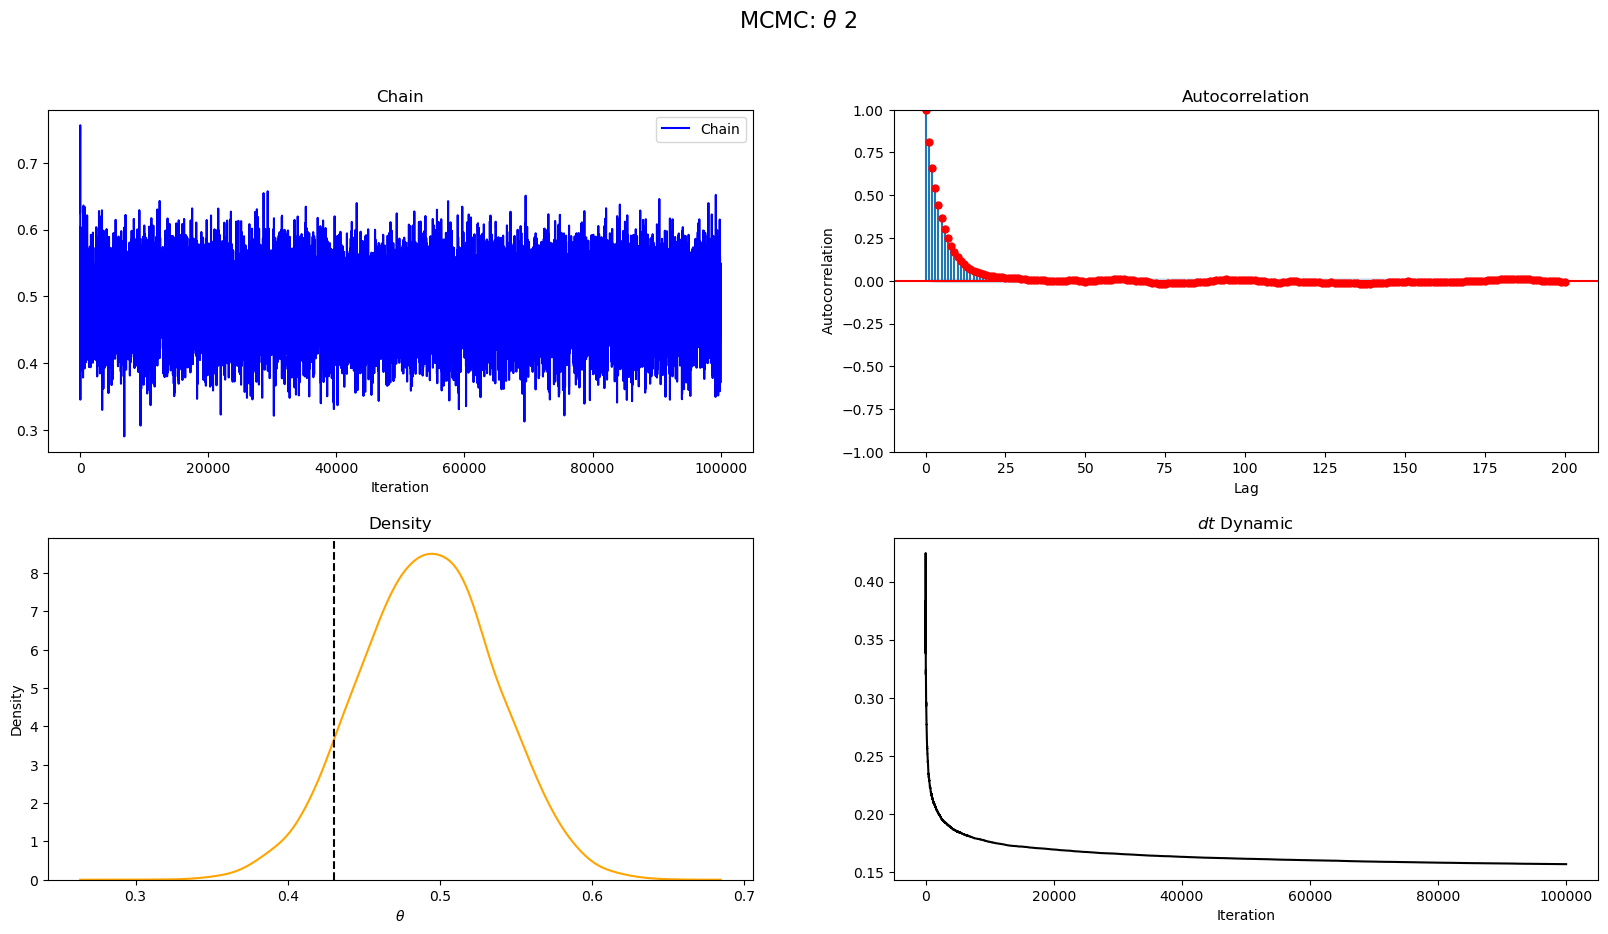

In [25]:
plot_mcmc_parameters(samples, theta_t, tracker, N, samples[nobs])

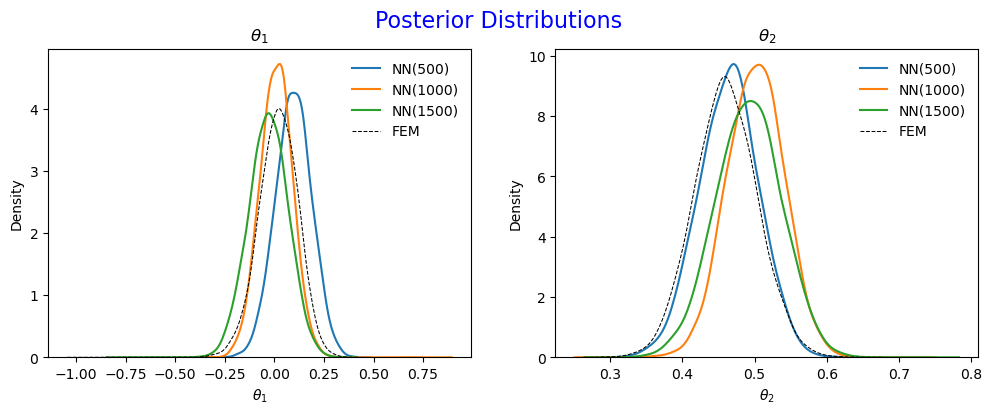

In [26]:
plot_posterior_distributions(samples, N, samp_num)

# Inverse Problem with Uncertainty in the Surrogate

In [27]:
deepGala = dict()

layers = [3] + 1*[20] + [1]

for nobs in N:
    data_int,left_bc,right_bc = generate_data(nobs)

    model = DNN(layers)
    path = f"./Models/1dElliptic_PDE2_w20_N{nobs}_batch150.pt"
    model.load_state_dict(torch.load(path))
    model.eval()

    pde = {"PDE":["de","bc_l","bc_r"], 
            "data_set":{"de" : Variable(data_int,requires_grad=True),
                    "bc_l":left_bc,
                    "bc_r" :right_bc}}

    llp = llaplace(model)
    llp.fit(pde=pde, hessian_structure = "full")

    log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
    
    for i in range(5000):
            hyper_optimizer.zero_grad()
            neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
            neg_marglik.backward(retain_graph=True)
            hyper_optimizer.step()
    deepGala[str(nobs)] = llp

In [ ]:
# # Plotting
# fig = plt.figure(figsize=(25,25))
# plt.subplots_adjust(hspace=0.25)
# colors = ["blue","orange","green"]

# for n,(pr1) in enumerate(param_test[:4]):

#     data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
#     numerical_sol = sol_test[n,:]

#     plt.subplot(8, 2, n + 1)
#     llp = deepGala[str(N[-1])]

#     u_mean, u_sigma = llp(data_test)
#     u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
#     numerical_sol = numerical_sol.reshape(u_mean.shape)

#     plt.scatter(x_test, u_mean, label = fr"NN_training_{1500}",alpha=0.6 )
#     plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

#     plt.plot(x_test, numerical_sol, label = "Numerical Solution")

#     plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend(frameon=False)

In [28]:
samples_dg,tracker_dg = dict(),dict()

# for nob in N:
#     dgl = deepGala[str(nob)]

#     sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=dgl ,sig = std,mean = False)
#     alpha_samples, dt_progression = sampler.run_sampler(n_chains=100000)
#     samples_dg[nob], tracker_dg[nob] = alpha_samples,dt_progression
    
#     np.save(f'./Models/dgl_{nob}_Samples.npy', samples_dg[nob])
#     np.save(f'./Models/dgl_{nob}_Step.npy', tracker_dg[nob])


for nob in N:
    samples_dg[nob]= np.load(f'./Models/dgl_{nob}_Samples.npy')
    tracker_dg[nob] = np.load(f'./Models/dgl_{nob}_Step.npy')

Iteration 0, Acceptance Rate: 0.000, Step Size: 0.3830
Iteration 10000, Acceptance Rate: 0.213, Step Size: 0.2598
Iteration 20000, Acceptance Rate: 0.214, Step Size: 0.2564
Iteration 30000, Acceptance Rate: 0.215, Step Size: 0.2543
Iteration 40000, Acceptance Rate: 0.218, Step Size: 0.2537
Iteration 50000, Acceptance Rate: 0.219, Step Size: 0.2531
Iteration 60000, Acceptance Rate: 0.220, Step Size: 0.2527
Iteration 70000, Acceptance Rate: 0.220, Step Size: 0.2521
Iteration 80000, Acceptance Rate: 0.220, Step Size: 0.2516
Iteration 90000, Acceptance Rate: 0.220, Step Size: 0.2512
Final Acceptance Rate: 0.220
Iteration 0, Acceptance Rate: 0.000, Step Size: 0.3837
Iteration 10000, Acceptance Rate: 0.182, Step Size: 0.1635
Iteration 20000, Acceptance Rate: 0.187, Step Size: 0.1590
Iteration 30000, Acceptance Rate: 0.190, Step Size: 0.1566
Iteration 40000, Acceptance Rate: 0.197, Step Size: 0.1556
Iteration 50000, Acceptance Rate: 0.199, Step Size: 0.1548
Iteration 60000, Acceptance Rate: 0

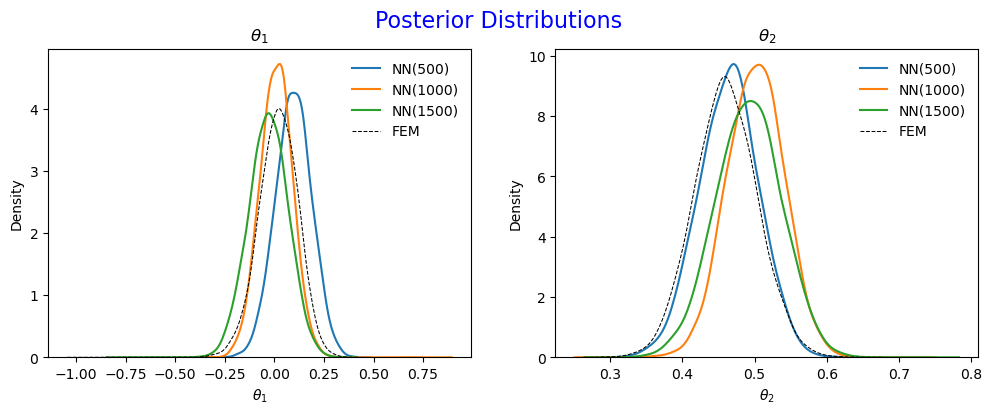

In [29]:
plot_posterior_distributions(samples, N, samp_num)

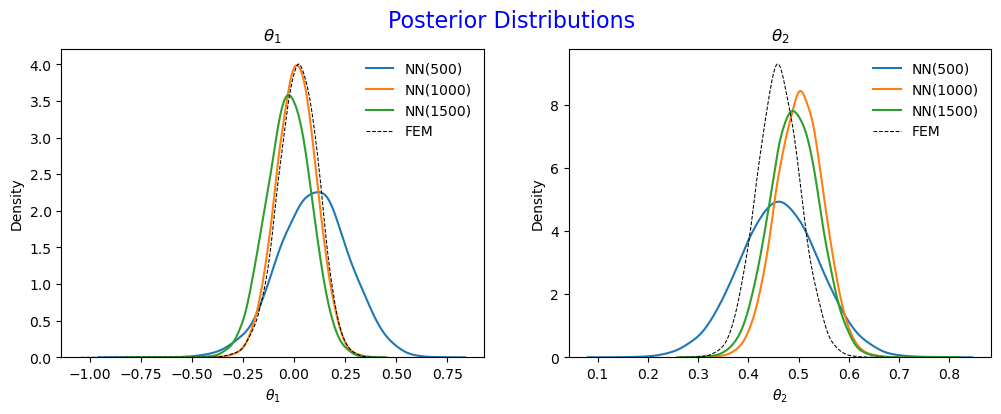

In [30]:
plot_posterior_distributions(samples_dg, N, samp_num)